In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
from get_draws.api import get_draws

import vivarium_helpers as vh
import vivarium_helpers.id_helper as idh
from vivarium_helpers.vph_output.operations import VPHOperator

!date
!whoami
!pwd

Fri Oct  3 11:31:28 PDT 2025
ndbs
/mnt/share/code/ndbs/vivarium_research_alzheimers/verification_and_validation


# V&V List

# Find data

In [2]:
# Project directory
%cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers


In [3]:
# Results directory containing model 5 results for all locations
!ls -halt results/model5.0/model_spec/2025_09_25_09_02_38/results/

total 106M
drwxrwsr-x 5 tylerdy IHME-Simulationscience 4.5K Sep 25 10:18 ..
drwxrwsr-x 2 tylerdy IHME-Simulationscience 3.0K Sep 25 09:36 .
-rw-rw-r-- 1 tylerdy IHME-Simulationscience 3.1M Sep 25 09:36 new_simulants.parquet
-rw-rw-r-- 1 tylerdy IHME-Simulationscience  15M Sep 25 09:36 person_time_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 tylerdy IHME-Simulationscience 4.6M Sep 25 09:36 deaths.parquet
-rw-rw-r-- 1 tylerdy IHME-Simulationscience 5.7M Sep 25 09:36 transition_count_alzheimers_disease_and_other_dementias.parquet
-rw-rw-r-- 1 tylerdy IHME-Simulationscience  51M Sep 25 09:36 ylds.parquet
-rw-rw-r-- 1 tylerdy IHME-Simulationscience  28M Sep 25 09:36 ylls.parquet


In [ ]:
locations = [
    'United States of America',
    'Brazil',
    'China',
    'Germany',
    'Israel',
    'Japan',
    'Spain',
    'Sweden',
    'Taiwan (Province of China)',
    'United Kingdom',
]

# Define some shorter names to use for plotting
location_to_short_name = ({loc: loc for loc in locations}| {
    'Taiwan (Province of China)': 'Taiwan',
    'United Kingdom': 'UK',
    'United States of America': 'USA',
})

# Select a subset of locations to draw plots for
locations_to_plot = locations[:2]

project_dir = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

results_dirs = [
    'results/model5.0/model_spec/2025_09_25_09_02_38/results/',
]

# # Option 1: One artifact per location
# location_to_results_dir = {
#     loc: project_dir + path for loc, path in zip(locations, results_dirs)}

# Option 2: All locations in one artifact
location_to_results_dir = {'all': project_dir + results_dirs[0]}

location_to_artifact_subdir = {loc: loc.lower().replace(' ', '_') for loc in locations}
artifact_subpaths = ['artifacts/model5.0/' + subdir + '.hdf' for subdir in location_to_artifact_subdir.values()]
location_to_artifact_path = {loc: project_dir + subpath for loc, subpath in zip(locations, artifact_subpaths)}
artifact_path_to_location = {path: loc for loc, path in location_to_artifact_path.items()}
# artifact_path_to_location = {project_dir + subpath: loc for subpath, loc in zip(artifact_subpaths, locations)}
artifact_path_to_location

{'/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/united_states_of_america.hdf': 'United States of America',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/brazil.hdf': 'Brazil',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/china.hdf': 'China',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/germany.hdf': 'Germany',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/israel.hdf': 'Israel',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/japan.hdf': 'Japan',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/spain.hdf': 'Spain',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/sweden.hdf': 'Sweden',
 '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model5.0/taiwan_(province_of

# Define and test function for reducing memory usage of DataFrames

In [5]:
test = pd.read_parquet(Path(results_dirs[0]) / 'deaths.parquet')
test

,measure,entity_type,entity,sub_entity,age_group,current_year,sex,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,499,2284,0.0
1,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Male,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,499,2284,0.0
2,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2026,Female,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,499,2284,0.0
3,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2026,Male,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,499,2284,0.0
4,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2027,Female,/mnt/team/simulation_science/pub/models/vivari...,499,baseline,499,2284,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699995,deaths,cause,other_causes,other_causes,95_plus,2098,Male,/mnt/team/simulation_science/pub/models/vivari...,199,baseline,199,5616,70.0
5699996,deaths,cause,other_causes,other_causes,95_plus,2099,Female,/mnt/team/simulation_science/pub/models/vivari...,199,baseline,199,5616,532.0
5699997,deaths,cause,other_causes,other_causes,95_plus,2099,Male,/mnt/team/simulation_science/pub/models/vivari...,199,baseline,199,5616,60.0
5699998,deaths,cause,other_causes,other_causes,95_plus,2100,Female,/mnt/team/simulation_science/pub/models/vivari...,199,baseline,199,5616,503.0


In [6]:
# The sub_entity column is superfluous in this dataframe
test.entity.equals(test.sub_entity)

True

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700000 entries, 0 to 5699999
Data columns (total 13 columns):
 #   Column             Dtype   
---  ------             -----   
 0   measure            object  
 1   entity_type        category
 2   entity             category
 3   sub_entity         category
 4   age_group          category
 5   current_year       category
 6   sex                category
 7   artifact_path      object  
 8   input_draw_number  int64   
 9   scenario           object  
 10  input_draw         int64   
 11  random_seed        int64   
 12  value              float64 
dtypes: category(6), float64(1), int64(3), object(3)
memory usage: 337.0+ MB


In [8]:
%%time

# # Groupbys didn't seem to work properly when I filled this column with NaNs
# test['sub_entity'] = pd.NA

def convert_to_categorical(df):
    for col in df:
        if df[col].dtype not in ('float', 'category'):
            df[col] = df[col].astype('category')

convert_to_categorical(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700000 entries, 0 to 5699999
Data columns (total 13 columns):
 #   Column             Dtype   
---  ------             -----   
 0   measure            category
 1   entity_type        category
 2   entity             category
 3   sub_entity         category
 4   age_group          category
 5   current_year       category
 6   sex                category
 7   artifact_path      category
 8   input_draw_number  category
 9   scenario           category
 10  input_draw         category
 11  random_seed        category
 12  value              float64 
dtypes: category(12), float64(1)
memory usage: 108.7 MB
CPU times: user 2.07 s, sys: 464 ms, total: 2.53 s
Wall time: 2.53 s


# Create VPHOperator object to perform operations on simulation output

In [9]:
ops = VPHOperator()
ops.index_cols.append('location')
ops.index_cols

['input_draw', 'scenario', 'location']

# Define function to load simulation output

In [10]:
def load_df(
        measure,
        results_dict=location_to_results_dir,
        artifact_path_to_location=artifact_path_to_location,
        drop_redundant_cols=True,
        force_categorical=True,
        aggregate_seeds=True,
        **kwargs, # keyword args to pass to .read_parquet
    ):
    dfs = []
    ops = VPHOperator() # Use default index columns
    for location, directory in results_dict.items():
        df = pd.read_parquet(Path(directory) / f'{measure}.parquet', **kwargs)
        if drop_redundant_cols:
            for col1, col2 in [
                ('input_draw', 'input_draw_number'),
                ('entity', 'sub_entity'),
            ]:
                if (col1 in df and col2 in df and df[col1].equals(df[col2])):
                    df.drop(columns=col2, inplace=True)
        if force_categorical:
            convert_to_categorical(df)
        if aggregate_seeds:
            df = ops.marginalize(df, 'random_seed')
        if location == 'all' and 'artifact_path' in df:
            df['location'] = df['artifact_path'].map(artifact_path_to_location)
        else:
            df['location'] = location
        dfs.append(df)
    df = pd.concat(dfs)
    return df

person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time

,age_group,artifact_path,current_year,entity,entity_type,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,person_time,baseline,Female,alzheimers_blood_based_biomarker_state,0.000000,Sweden
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,person_time,baseline,Female,alzheimers_mild_cognitive_impairment_state,0.000000,Sweden
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,person_time,baseline,Female,alzheimers_disease_state,0.000000,Sweden
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,person_time,baseline,Male,alzheimers_blood_based_biomarker_state,0.000000,Sweden
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,person_time,baseline,Male,alzheimers_mild_cognitive_impairment_state,0.000000,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...
1709995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,alzheimers_disease_and_other_dementias,cause,169,person_time,baseline,Female,alzheimers_mild_cognitive_impairment_state,2029.158111,Brazil
1709996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,alzheimers_disease_and_other_dementias,cause,169,person_time,baseline,Female,alzheimers_disease_state,17551.967146,Brazil
1709997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,alzheimers_disease_and_other_dementias,cause,169,person_time,baseline,Male,alzheimers_blood_based_biomarker_state,1776.640657,Brazil
1709998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,alzheimers_disease_and_other_dementias,cause,169,person_time,baseline,Male,alzheimers_mild_cognitive_impairment_state,1051.154004,Brazil


In [11]:
# Check that locations got mapped correctly
person_time.location.unique()

['Sweden', 'Germany', 'Japan', 'Spain', 'United Kingdom', 'Taiwan (Province of China)', 'United States of America', 'China', 'Israel', 'Brazil']
Categories (10, object): ['Brazil', 'China', 'Germany', 'Israel', ..., 'Sweden', 'Taiwan (Province of China)', 'United Kingdom', 'United States of America']

In [12]:
person_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710000 entries, 0 to 1709999
Data columns (total 12 columns):
 #   Column         Dtype   
---  ------         -----   
 0   age_group      category
 1   artifact_path  category
 2   current_year   category
 3   entity         category
 4   entity_type    category
 5   input_draw     category
 6   measure        category
 7   scenario       category
 8   sex            category
 9   sub_entity     category
 10  value          float64 
 11  location       category
dtypes: category(11), float64(1)
memory usage: 31.0 MB


# Get list of draws used in the sim, and the corresponding Artifact columns

In [105]:
sim_draws = person_time.input_draw.unique().sort_values()
draw_cols = [f'draw_{i}' for i in sim_draws]
sim_draws

[2, 13, 24, 41, 46, ..., 446, 457, 460, 480, 499]
Length: 25
Categories (25, int64): [2, 13, 24, 41, ..., 457, 460, 480, 499]

# Load YLDs to compute disability weights

In [13]:
%%time
ylds = load_df('ylds')
ylds

CPU times: user 12.4 s, sys: 3.44 s, total: 15.8 s
Wall time: 11.4 s


,age_group,artifact_path,current_year,entity,entity_type,input_draw,measure,scenario,sex,sub_entity,value,location
0,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,ylds,baseline,Female,alzheimers_blood_based_biomarker_state,0.000000,Sweden
1,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,ylds,baseline,Female,alzheimers_mild_cognitive_impairment_state,0.000000,Sweden
2,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,ylds,baseline,Female,alzheimers_disease_state,0.000000,Sweden
3,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,ylds,baseline,Male,alzheimers_blood_based_biomarker_state,0.000000,Sweden
4,25_to_29,/mnt/team/simulation_science/pub/models/vivari...,2025,alzheimers_disease_and_other_dementias,cause,499,ylds,baseline,Male,alzheimers_mild_cognitive_impairment_state,0.000000,Sweden
...,...,...,...,...,...,...,...,...,...,...,...,...
2279995,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,all_causes,cause,199,ylds,baseline,Male,all_causes,1217.536175,Brazil
2279996,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,all_causes,cause,265,ylds,baseline,Female,all_causes,4835.131363,Brazil
2279997,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,all_causes,cause,265,ylds,baseline,Male,all_causes,2756.038204,Brazil
2279998,95_plus,/mnt/team/simulation_science/pub/models/vivari...,2100,all_causes,cause,169,ylds,baseline,Female,all_causes,5259.934842,Brazil


# Compute observed disability weights for all 3 AD states

In [14]:
# Compute disability weights for each disease state, aggregating across
# years, age groups, and sexes
dws_overall = ops.ratio(
    ylds.query("entity == 'alzheimers_disease_and_other_dementias'"),
    person_time,
    strata = ['sub_entity'],
)
dws_overall

,sub_entity,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_blood_based_biomarker_state,2,baseline,Brazil,0.000000,ylds,person_time,1
1,alzheimers_blood_based_biomarker_state,2,baseline,China,0.000000,ylds,person_time,1
2,alzheimers_blood_based_biomarker_state,2,baseline,Germany,0.000000,ylds,person_time,1
3,alzheimers_blood_based_biomarker_state,2,baseline,Israel,0.000000,ylds,person_time,1
4,alzheimers_blood_based_biomarker_state,2,baseline,Japan,0.000000,ylds,person_time,1
...,...,...,...,...,...,...,...,...
745,alzheimers_mild_cognitive_impairment_state,499,baseline,Spain,0.016145,ylds,person_time,1
746,alzheimers_mild_cognitive_impairment_state,499,baseline,Sweden,0.016145,ylds,person_time,1
747,alzheimers_mild_cognitive_impairment_state,499,baseline,Taiwan (Province of China),0.016145,ylds,person_time,1
748,alzheimers_mild_cognitive_impairment_state,499,baseline,United Kingdom,0.016145,ylds,person_time,1


In [15]:
# For each location, check mean and std across draws in each disease
# state. The means and standard deviations across draws should be
# similar between locations -- looks good
dws_overall.groupby(['location', 'sub_entity'])['value'].agg(['mean', 'std']).unstack()

mean  \
sub_entity                 alzheimers_blood_based_biomarker_state   
location                                                            
Brazil                                                        0.0   
China                                                         0.0   
Germany                                                       0.0   
Israel                                                        0.0   
Japan                                                         0.0   
Spain                                                         0.0   
Sweden                                                        0.0   
Taiwan (Province of China)                                    0.0   
United Kingdom                                                0.0   
United States of America                                      0.0   

                                                     \
sub_entity                 alzheimers_disease_state   
location                                              
Brazil                                     0.256193   
China                                      0.256644   
Germany                                    0.259200   
Israel                                     0.256672   
Japan                                      0.265856   
Spain                                      0.258840   
Sweden                                     0.259732   
Taiwan (Province of China)                 0.261778   
United Kingdom                             0.258611   
United States of America                   0.257233   

                                                                       \
sub_entity                 alzheimers_mild_cognitive_impairment_state   
location                                                                
Brazil                                                       0.021442   
China                                                        0.021442   
Germany                                                      0.021442   
Israel                                                       0.021442   
Japan                                                        0.021442   
Spain                                                        0.021442   
Sweden                                                       0.021442   
Taiwan (Province of China)                                   0.021442   
United Kingdom                                               0.021442   
United States of America                                     0.021442   

                                                              std  \
sub_entity                 alzheimers_blood_based_biomarker_state   
location                                                            
Brazil                                                        0.0   
China                                                         0.0   
Germany                                                       0.0   
Israel                                                        0.0   
Japan                                                         0.0   
Spain                                                         0.0   
Sweden                                                        0.0   
Taiwan (Province of China)                                    0.0   
United Kingdom                                                0.0   
United States of America                                      0.0   

                                                     \
sub_entity                 alzheimers_disease_state   
location                                              
Brazil                                     0.049115   
China                                      0.049740   
Germany                                    0.049998   
Israel                                     0.049515   
Japan                                      0.050795   
Spain                                      0.050009   
Sweden                                     0.049823   
Taiwan (Province of China)                 0.0504

In [16]:
# For each draw, check mean and std across locations in each disease
# state. The standard deviation across locations should be small --
# looks good
dws_overall.groupby(['input_draw', 'sub_entity'])['value'].agg(['mean', 'std']).unstack()

mean                           \
sub_entity alzheimers_blood_based_biomarker_state alzheimers_disease_state   
input_draw                                                                   
2                                             0.0                 0.227268   
13                                            0.0                 0.268523   
24                                            0.0                 0.222323   
41                                            0.0                 0.198929   
46                                            0.0                 0.231072   
89                                            0.0                 0.294249   
113                                           0.0                 0.220904   
158                                           0.0                 0.217743   
169                                           0.0                 0.244542   
177                                           0.0                 0.321614   
199                                           0.0                 0.272321   
258                                           0.0                 0.252329   
262                                           0.0                 0.288713   
265                                           0.0                 0.265178   
273                                           0.0                 0.323552   
317                                           0.0                 0.271496   
323                                           0.0                 0.288295   
346                                           0.0                 0.188571   
356                                           0.0                 0.391053   
392                                           0.0                 0.245359   
446                                           0.0                 0.272629   
457                                           0.0                 0.343473   
460                                           0.0                 0.210439   
480                                           0.0                 0.225542   
499                                           0.0                 0.190781   

                                                       \
sub_entity alzheimers_mild_cognitive_impairment_state   
input_draw                                              
2                                            0.017713   
13                                           0.026830   
24                                           0.016832   
41                                           0.018522   
46                                           0.017468   
89                                           0.029887   
113                                          0.020836   
158                                          0.014392   
169                                          0.027174   
177                                          0.014766   
199                                          0.020372   
258                                          0.022537   
262                                          0.017911   
265                                          0.023393   
273                                          0.013341   
317                                          0.019113   
323                                          0.027104   
346                                          0.014362   
356                                          0.039072   
392                                          0.020080   
446                                          0.026344   
457                                          0.027967   
460                                          0.026160   
480                                          0.017734   
499                                          0.016145   

                                              std                           \
sub_entity alzheimers_blood_based_biomarker_state alzheimers_disease_state   
input_draw                                                                   
2                            

In [17]:
# Compute disability weights for each cause state in each age group,
# aggregating over years and sexes
dws_by_age_group = ops.ratio(
    ylds.query("entity == 'alzheimers_disease_and_other_dementias'"),
    person_time,
    strata = ['sub_entity', 'age_group'],
)
dws_by_age_group

,sub_entity,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Brazil,0.000000,ylds,person_time,1
1,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,China,0.000000,ylds,person_time,1
2,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Germany,0.000000,ylds,person_time,1
3,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Israel,0.000000,ylds,person_time,1
4,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Japan,0.000000,ylds,person_time,1
...,...,...,...,...,...,...,...,...,...
11245,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,Spain,0.016145,ylds,person_time,1
11246,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,Sweden,0.016145,ylds,person_time,1
11247,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,Taiwan (Province of China),0.016145,ylds,person_time,1
11248,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,United Kingdom,0.016145,ylds,person_time,1


In [18]:
# For each draw, compute mean and standard deviation across locations
# and age groups in each disease state. The standard deviation of the
# MCI disability weight should be small because it doesn't depend on
# age, but the DW of AD-dementia depends on the sequela prevalences,
# which are age-dependent, so we expect to see a larger standard
# deviation here -- looks good. 
dws_by_age_group.groupby(['input_draw', 'sub_entity'])['value'].agg(['mean', 'std']).unstack()

mean                           \
sub_entity alzheimers_blood_based_biomarker_state alzheimers_disease_state   
input_draw                                                                   
2                                             0.0                 0.170940   
13                                            0.0                 0.195277   
24                                            0.0                 0.168893   
41                                            0.0                 0.145247   
46                                            0.0                 0.170171   
89                                            0.0                 0.212613   
113                                           0.0                 0.171200   
158                                           0.0                 0.158461   
169                                           0.0                 0.177114   
177                                           0.0                 0.233066   
199                                           0.0                 0.194356   
258                                           0.0                 0.188748   
262                                           0.0                 0.209719   
265                                           0.0                 0.190042   
273                                           0.0                 0.241029   
317                                           0.0                 0.198561   
323                                           0.0                 0.213278   
346                                           0.0                 0.149439   
356                                           0.0                 0.283028   
392                                           0.0                 0.182294   
446                                           0.0                 0.199772   
457                                           0.0                 0.247977   
460                                           0.0                 0.158068   
480                                           0.0                 0.171244   
499                                           0.0                 0.143697   

                                                       \
sub_entity alzheimers_mild_cognitive_impairment_state   
input_draw                                              
2                                            0.017713   
13                                           0.026830   
24                                           0.016832   
41                                           0.018522   
46                                           0.017468   
89                                           0.029887   
113                                          0.020836   
158                                          0.014392   
169                                          0.027174   
177                                          0.014766   
199                                          0.020372   
258                                          0.022537   
262                                          0.017911   
265                                          0.023393   
273                                          0.013341   
317                                          0.019113   
323                                          0.027104   
346                                          0.014362   
356                                          0.039072   
392                                          0.020080   
446                                          0.026344   
457                                          0.027967   
460                                          0.026160   
480                                          0.017734   
499                                          0.016145   

                                              std                           \
sub_entity alzheimers_blood_based_biomarker_state alzheimers_disease_state   
input_draw                                                                   
2                            

# Load Artifact data

In [19]:
location = locations[0]
art = Artifact(location_to_artifact_path[location])
print(art.load('metadata.locations'))
print(art)

['United States of America']
Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		cause_specific_mortality_rate
		excess_mortality_rate
		disability_weight
		restrictions
covariate
	live_births_by_sex
		estimate



# Get age bins and add an `age_group` column to match sim output

In [57]:
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
)
age_dictionary

,age_group_id,age_group_name,age_start,age_end,age_group
0,6,5 to 9,5.0,10.0,5_to_9
1,7,10 to 14,10.0,15.0,10_to_14
2,8,15 to 19,15.0,20.0,15_to_19
3,9,20 to 24,20.0,25.0,20_to_24
4,10,25 to 29,25.0,30.0,25_to_29
5,11,30 to 34,30.0,35.0,30_to_34
6,12,35 to 39,35.0,40.0,35_to_39
7,13,40 to 44,40.0,45.0,40_to_44
8,14,45 to 49,45.0,50.0,45_to_49
9,15,50 to 54,50.0,55.0,50_to_54


# Get MCI-AD and AD-dementia disability weights by age and sex to match Artifact

In [141]:
# Compute disability weights for each cause state in each age group,
# aggregating over years and sexes
dws_by_age_group_and_sex = ops.ratio(
    ylds.query("entity == 'alzheimers_disease_and_other_dementias'"),
    person_time,
    strata = ['sub_entity', 'age_group', 'sex'],
)
dws_by_age_group_and_sex

,sub_entity,age_group,sex,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_blood_based_biomarker_state,25_to_29,Female,2,baseline,Brazil,0.000000,ylds,person_time,1
1,alzheimers_blood_based_biomarker_state,25_to_29,Female,2,baseline,China,0.000000,ylds,person_time,1
2,alzheimers_blood_based_biomarker_state,25_to_29,Female,2,baseline,Germany,0.000000,ylds,person_time,1
3,alzheimers_blood_based_biomarker_state,25_to_29,Female,2,baseline,Israel,0.000000,ylds,person_time,1
4,alzheimers_blood_based_biomarker_state,25_to_29,Female,2,baseline,Japan,0.000000,ylds,person_time,1
...,...,...,...,...,...,...,...,...,...,...
22495,alzheimers_mild_cognitive_impairment_state,95_plus,Male,499,baseline,Spain,0.016145,ylds,person_time,1
22496,alzheimers_mild_cognitive_impairment_state,95_plus,Male,499,baseline,Sweden,0.016145,ylds,person_time,1
22497,alzheimers_mild_cognitive_impairment_state,95_plus,Male,499,baseline,Taiwan (Province of China),0.016145,ylds,person_time,1
22498,alzheimers_mild_cognitive_impairment_state,95_plus,Male,499,baseline,United Kingdom,0.016145,ylds,person_time,1


In [151]:
ops.value(
    dws_by_age_group_and_sex.query("sub_entity=='alzheimers_disease_state'")
).unstack('input_draw')

value  \
input_draw                                                                                                                           2     
age_group denominator_measure location                   multiplier numerator_measure scenario sex    sub_entity                           
25_to_29  person_time         Brazil                     1          ylds              baseline Female alzheimers_disease_state  0.000000   
                                                                                               Male   alzheimers_disease_state       NaN   
                              China                      1          ylds              baseline Female alzheimers_disease_state  0.000000   
                                                                                               Male   alzheimers_disease_state       NaN   
                              Germany                    1          ylds              baseline Female alzheimers_disease_state  0.000000   
...                                                                                                                                  ...   
95_plus   person_time         Taiwan (Province of China) 1          ylds              baseline Male   alzheimers_disease_state  0.258203   
                              United Kingdom             1          ylds              baseline Female alzheimers_disease_state  0.315896   
                                                                                               Male   alzheimers_disease_state  0.258203   
                              United States of America   1          ylds              baseline Female alzheimers_disease_state  0.315896   
                                                                                               Male   alzheimers_disease_state  0.258203   

                                                                                                                                          \
input_draw                                                                                                                           13    
age_group denominator_measure location                   multiplier numerator_measure scenario sex    sub_entity                           
25_to_29  person_time         Brazil                     1          ylds              baseline Female alzheimers_disease_state  0.000000   
                                                                                               Male   alzheimers_disease_state  0.000000   
                              China                      1          ylds              baseline Female alzheimers_disease_state  0.000000   
                                                                                               Male   alzheimers_disease_state  0.000000   
                              Germany                    1          ylds              baseline Female alzheimers_disease_state  0.000000   
...                                                                                                                                  ...   
95_plus   person_time         Taiwan (Province of China) 1          ylds              baseline Male   alzheimers_disease_state  0.281375   
                              United Kingdom             1          ylds              baseline Female alzheimers_disease_state  0.350361   
                                                                                               Male   alzheimers_disease_state  0.281375   
                              United States of America   1          ylds              baseline Female alzheimers_disease_state  0.350361   
                                                                                               Male   alzheimers_disease_state  0.281375   

                                                                                                                                          \
input_draw                                                           

# Define a function to load and merge Artifact data from all locations

In [185]:
art.load('metadata.locations')

['United States of America']

In [ ]:
def load_artifact_data(
    key,
    filter_terms=None,
    location_to_artifact_path=location_to_artifact_path,
):
    dfs = {} # dict to map locations to artifact data
    for location, path in location_to_artifact_path.items():
        art = Artifact(path, filter_terms)
        # Check to make sure location matches artifact
        art_locations = art.load('metadata.locations')
        assert len(art_locations) == 1 and art_locations[0] == location, \
            f'Unexpected locations in artifact: {location=}, {art_locations=}'
        df = art.load(key)
        dfs[location] = df
    data = pd.concat(dfs, names=['location', *df.index.names])
    return data

ad_dw = load_artifact_data(
    'cause.alzheimers_disease_and_other_dementias.disability_weight',
    ['age_start >= 25'],
)
ad_dw

draw_0  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.000000   
                                30.0      35.0    2021       2022      0.000000   
                                35.0      40.0    2021       2022      0.000000   
                                40.0      45.0    2021       2022      0.202079   
                                45.0      50.0    2021       2022      0.335755   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.278205   
                                80.0      85.0    2021       2022      0.306796   
                                85.0      90.0    2021       2022      0.338259   
                                90.0      95.0    2021       2022      0.322863   
                                95.0      125.0   2021       2022      0.360485   

                                                                         draw_1  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.000000   
                                30.0      35.0    2021       2022      0.000000   
                                35.0      40.0    2021       2022      0.000000   
                                40.0      45.0    2021       2022      0.183388   
                                45.0      50.0    2021       2022      0.195241   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.241661   
                                80.0      85.0    2021       2022      0.261933   
                                85.0      90.0    2021       2022      0.275970   
                                90.0      95.0    2021       2022      0.291398   
                                95.0      125.0   2021       2022      0.301009   

                                                                         draw_2  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.000000   
                                30.0      35.0    2021       2022      0.000000   
                                35.0      40.0    2021       2022      0.000000   
                                40.0      45.0    2021       2022      0.171015   
                                45.0      50.0    2021       2022      0.172305   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.204588   
                                80.0      85.0    2021       2022      0.202641   
                                85.0      90.0    2021       2022      0.219389   
                                90.0      95.0    2021       2022      0.219160   
                                95.0      125.0   2021       2022      0.258203   

                                                                         draw_3  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.000000   
                                30.0      35.0    2021       2022      0.000000   
                                35.0      40.0    2021       2022      0.000000   
                                40.0      45.0    2021       2022      0.118582   
                                45.0      50.0    2021       2022      0.124493   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.133820   
                                80.0      85.0    2021       2022      0.144683   
   

In [142]:
ad_dw.query("age_start == 50")

draw_0  \
location                   sex    age_start age_end year_start year_end             
United States of America   Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Brazil                     Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
China                      Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Germany                    Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Israel                     Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Japan                      Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Spain                      Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Sweden                     Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
Taiwan (Province of China) Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   
United Kingdom             Female 50.0      55.0    2021       2022      0.291097   
                           Male   50.0      55.0    2021       2022      0.228350   

                                                                          draw_1  \
location                   sex    age_start age_end year_start year_end            
United States of America   Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Brazil                     Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
China                      Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Germany                    Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Israel                     Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Japan                      Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Spain                      Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Sweden                     Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
Taiwan (Province of China) Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   
United Kingdom             Female 50.0      55.0    2021       2022      0.19484   
                           Male   50.0      55.0    2021       2022      0.21682   

                                                                          draw_2  \
location                   sex    age_start age_end year_start year_end            
United States of America   Female 50.0      55.0    2021       2022      0.18672   
                           Male   50.0      55.0    2021       2022      0.16534   
Brazil             

In [109]:
mci_dw = load_artifact_data(
    'cause.alzheimers.mci_disability_weight',
    ['age_start >= 25']
    )
mci_dw

draw_0  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.031158   
                                30.0      35.0    2021       2022      0.031158   
                                35.0      40.0    2021       2022      0.031158   
                                40.0      45.0    2021       2022      0.031158   
                                45.0      50.0    2021       2022      0.031158   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.031158   
                                80.0      85.0    2021       2022      0.031158   
                                85.0      90.0    2021       2022      0.031158   
                                90.0      95.0    2021       2022      0.031158   
                                95.0      125.0   2021       2022      0.031158   

                                                                         draw_1  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.022772   
                                30.0      35.0    2021       2022      0.022772   
                                35.0      40.0    2021       2022      0.022772   
                                40.0      45.0    2021       2022      0.022772   
                                45.0      50.0    2021       2022      0.022772   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.022772   
                                80.0      85.0    2021       2022      0.022772   
                                85.0      90.0    2021       2022      0.022772   
                                90.0      95.0    2021       2022      0.022772   
                                95.0      125.0   2021       2022      0.022772   

                                                                         draw_2  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.017713   
                                30.0      35.0    2021       2022      0.017713   
                                35.0      40.0    2021       2022      0.017713   
                                40.0      45.0    2021       2022      0.017713   
                                45.0      50.0    2021       2022      0.017713   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.017713   
                                80.0      85.0    2021       2022      0.017713   
                                85.0      90.0    2021       2022      0.017713   
                                90.0      95.0    2021       2022      0.017713   
                                95.0      125.0   2021       2022      0.017713   

                                                                         draw_3  \
location                 sex    age_start age_end year_start year_end             
United States of America Female 25.0      30.0    2021       2022      0.010454   
                                30.0      35.0    2021       2022      0.010454   
                                35.0      40.0    2021       2022      0.010454   
                                40.0      45.0    2021       2022      0.010454   
                                45.0      50.0    2021       2022      0.010454   
...                                                                         ...   
United Kingdom           Male   75.0      80.0    2021       2022      0.010454   
                                80.0      85.0    2021       2022      0.010454   
   

In [110]:
# ad_dw = art.load('cause.alzheimers_disease_and_other_dementias.disability_weight')
# ad_dw

In [111]:
ad_dw_by_age_group = ad_dw.groupby(['age_start']).mean()
ad_dw_by_age_group.agg(['mean', 'std'])[draw_cols].T

,mean,std
draw_2,0.168037,0.091827
draw_13,0.189272,0.104742
draw_24,0.165023,0.088821
draw_41,0.141203,0.079333
draw_46,0.163678,0.091103
draw_89,0.209925,0.115597
draw_113,0.165129,0.089065
draw_158,0.155427,0.084431
draw_169,0.175700,0.095605
draw_177,0.230639,0.127416


# Define functions to summarize artifact data and simulation data for plotting

In [112]:
def lower(x):
    return x.quantile(0.025)

def upper(x):
    return x.quantile(0.975)

def summarize_artifact_data(df):
    summary = df.agg(['mean', lower, upper], axis='columns')
    return summary

summarize_artifact_data(ad_dw_by_age_group)

,mean,lower,upper
age_start,,,
25.0,0.000000,0.000000,0.000000
30.0,0.000000,0.000000,0.000000
35.0,0.000000,0.000000,0.000000
40.0,0.189708,0.121365,0.270591
45.0,0.197065,0.127457,0.275897
50.0,0.202335,0.131459,0.282345
55.0,0.210426,0.144188,0.276297
60.0,0.218167,0.145490,0.292869
65.0,0.227261,0.158161,0.307769


In [115]:
ad_dw_by_location_and_age = ad_dw.groupby(['location', 'age_start']).mean()
ad_dw_by_location_and_age

draw_0    draw_1    draw_2    draw_3  \
location                 age_start                                           
Brazil                   25.0       0.000000  0.000000  0.000000  0.000000   
                         30.0       0.000000  0.000000  0.000000  0.000000   
                         35.0       0.000000  0.000000  0.000000  0.000000   
                         40.0       0.209945  0.211164  0.176250  0.107838   
                         45.0       0.275260  0.194658  0.198124  0.126516   
...                                      ...       ...       ...       ...   
United States of America 75.0       0.296435  0.258406  0.211642  0.138345   
                         80.0       0.320012  0.282412  0.209811  0.148621   
                         85.0       0.359502  0.285590  0.229479  0.165664   
                         90.0       0.373297  0.310760  0.245675  0.172032   
                         95.0       0.395550  0.323121  0.287050  0.169662   

                                      draw_4    draw_5    draw_6    draw_7  \
location                 age_start                                           
Brazil                   25.0       0.000000  0.000000  0.000000  0.000000   
                         30.0       0.000000  0.000000  0.000000  0.000000   
                         35.0       0.000000  0.000000  0.000000  0.000000   
                         40.0       0.120351  0.143767  0.190097  0.231756   
                         45.0       0.166200  0.165514  0.201997  0.208614   
...                                      ...       ...       ...       ...   
United States of America 75.0       0.172265  0.151260  0.207559  0.248942   
                         80.0       0.191802  0.173415  0.244992  0.254659   
                         85.0       0.221446  0.189597  0.255145  0.307264   
                         90.0       0.245476  0.191264  0.265277  0.303671   
                         95.0       0.237213  0.209273  0.303096  0.341878   

                                      draw_8    draw_9  ...  draw_490  \
location                 age_start                      ...             
Brazil                   25.0       0.000000  0.000000  ...  0.000000   
                         30.0       0.000000  0.000000  ...  0.000000   
                         35.0       0.000000  0.000000  ...  0.000000   
                         40.0       0.159360  0.138575  ...  0.208195   
                         45.0       0.181099  0.167771  ...  0.225634   
...                                      ...       ...  ...       ...   
United States of America 75.0       0.213639  0.192706  ...  0.269578   
                         80.0       0.236409  0.189671  ...  0.275587   
                         85.0       0.278753  0.208764  ...  0.303486   
                         90.0       0.280716  0.248129  ...  0.317002   
                         95.0       0.319879  0.253683  ...  0.353836   

                                    draw_491  draw_492  draw_493  draw_494  \
location                 age_start                                           
Brazil                   25.0       0.000000  0.000000  0.000000  0.000000   
                         30.0       0.000000  0.000000  0.000000  0.000000   
                         35.0       0.000000  0.000000  0.000000  0.000000   
                         40.0       0.194207  0.198622  0.228685  0.205725   
                         45.0       0.177718  0.178978  0.276473  0.182853   
...                                      ...       ...       ...       ...   
United States of America 75.0       0.204679  0.212774  0.266247  0.290744   
                         80.0       0.242278  0.272910  0.290705  0.305055   
                         85.0       0.238274  0.291657  0.292962  0.314712   
                         90.0       0.267577  0.293202  0.355964  0.373732   
                         95.0       0.279274  0.301214  0.325677  0.367116   

                                    draw_49

In [ ]:
def summarize_sim_data(df, age_dictionary=age_dictionary):
    # Merge to get an age_start column for plotting
    if 'age_group' in df:
        df = df.merge(age_dictionary, on='age_group')
    # Summarize, and rename percentiles to match artifact
    summary = ops.describe(df).rename(
        columns={'2.5%': 'lower', '97.5%': 'upper'})
    return summary

summarize_sim_data(dws_by_age_group)

count  \
age_end age_group age_group_id age_group_name age_start denominator_measure location                 multiplier numerator_measure scenario sub_entity                                          
30.0    25_to_29  10           25 to 29       25.0      person_time         Brazil                   1          ylds              baseline alzheimers_blood_based_biomarker_state       25.0   
                                                                                                                                           alzheimers_disease_state                     25.0   
                                                                                                                                           alzheimers_mild_cognitive_impairment_state   25.0   
                                                                            China                    1          ylds              baseline alzheimers_blood_based_biomarker_state       25.0   
                                                                                                                                           alzheimers_disease_state                     24.0   
...                                                                                                                                                                                      ...   
125.0   95_plus   235          95 plus        95.0      person_time         United Kingdom           1          ylds              baseline alzheimers_disease_state                     25.0   
                                                                                                                                           alzheimers_mild_cognitive_impairment_state   25.0   
                                                                            United States of America 1          ylds              baseline alzheimers_blood_based_biomarker_state       25.0   
                                                                                                                                           alzheimers_disease_state                     25.0   
                                                                                                                                           alzheimers_mild_cognitive_impairment_state   25.0   

                                                                                                                                                                                           mean  \
age_end age_group age_group_id age_group_name age_start denominator_measure location                 multiplier numerator_measure scenario sub_entity                                             
30.0    25_to_29  10           25 to 29       25.0      person_time         Brazil                   1          ylds              baseline alzheimers_blood_based_biomarker_state      0.000000   
                                                                                                                                           alzheimers_disease_state                    0.000000   
                                                                                                                                           alzheimers_mild_cognitive_impairment_state  0.021442   
                                                                            China                    1          ylds              baseline alzheimers_blood_based_biomarker_state      0.000000   
                                                                                                                                           alzheimers_disease_state                    0.000000   
...                                                                                                                                                                                         ...   
125.0   95_plus   235          95 plus        95.0      person_time         United Kingdom           1          ylds          

In [119]:
art_summary = summarize_artifact_data(
    # mci_dw[draw_cols].assign(location=location).groupby('location').mean()
    mci_dw[draw_cols].groupby('location').mean(),
)
art_summary

,mean,lower,upper
location,,,
Brazil,0.021442,0.013954,0.033561
China,0.021442,0.013954,0.033561
Germany,0.021442,0.013954,0.033561
Israel,0.021442,0.013954,0.033561
Japan,0.021442,0.013954,0.033561
Spain,0.021442,0.013954,0.033561
Sweden,0.021442,0.013954,0.033561
Taiwan (Province of China),0.021442,0.013954,0.033561
United Kingdom,0.021442,0.013954,0.033561


In [132]:
dws_by_age_group#.groupby('location')['value'].mean()

,sub_entity,age_group,input_draw,scenario,location,value,numerator_measure,denominator_measure,multiplier
0,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Brazil,0.000000,ylds,person_time,1
1,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,China,0.000000,ylds,person_time,1
2,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Germany,0.000000,ylds,person_time,1
3,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Israel,0.000000,ylds,person_time,1
4,alzheimers_blood_based_biomarker_state,25_to_29,2,baseline,Japan,0.000000,ylds,person_time,1
...,...,...,...,...,...,...,...,...,...
11245,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,Spain,0.016145,ylds,person_time,1
11246,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,Sweden,0.016145,ylds,person_time,1
11247,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,Taiwan (Province of China),0.016145,ylds,person_time,1
11248,alzheimers_mild_cognitive_impairment_state,95_plus,499,baseline,United Kingdom,0.016145,ylds,person_time,1


In [138]:
state = 'alzheimers_disease_state'
# state = 'alzheimers_mild_cognitive_impairment_state'
sim_summary = summarize_sim_data(
        ops.marginalize(dws_by_age_group.query("sub_entity == @state"), 'age_group', func='mean')
        # .groupby('location')[['value']].mean()
)
sim_summary

count  \
denominator_measure location                   multiplier numerator_measure scenario sub_entity                        
person_time         Brazil                     1          ylds              baseline alzheimers_disease_state   25.0   
                    China                      1          ylds              baseline alzheimers_disease_state   25.0   
                    Germany                    1          ylds              baseline alzheimers_disease_state   25.0   
                    Israel                     1          ylds              baseline alzheimers_disease_state   25.0   
                    Japan                      1          ylds              baseline alzheimers_disease_state   25.0   
                    Spain                      1          ylds              baseline alzheimers_disease_state   25.0   
                    Sweden                     1          ylds              baseline alzheimers_disease_state   25.0   
                    Taiwan (Province of China) 1          ylds              baseline alzheimers_disease_state   25.0   
                    United Kingdom             1          ylds              baseline alzheimers_disease_state   25.0   
                    United States of America   1          ylds              baseline alzheimers_disease_state   25.0   

                                                                                                                   mean  \
denominator_measure location                   multiplier numerator_measure scenario sub_entity                           
person_time         Brazil                     1          ylds              baseline alzheimers_disease_state  0.189669   
                    China                      1          ylds              baseline alzheimers_disease_state  0.190950   
                    Germany                    1          ylds              baseline alzheimers_disease_state  0.193434   
                    Israel                     1          ylds              baseline alzheimers_disease_state  0.189372   
                    Japan                      1          ylds              baseline alzheimers_disease_state  0.193766   
                    Spain                      1          ylds              baseline alzheimers_disease_state  0.190511   
                    Sweden                     1          ylds              baseline alzheimers_disease_state  0.189931   
                    Taiwan (Province of China) 1          ylds              baseline alzheimers_disease_state  0.192368   
                    United Kingdom             1          ylds              baseline alzheimers_disease_state  0.190512   
                    United States of America   1          ylds              baseline alzheimers_disease_state  0.189660   

                                                                                                                    std  \
denominator_measure location                   multiplier numerator_measure scenario sub_entity                           
person_time         Brazil                     1          ylds              baseline alzheimers_disease_state  0.034942   
                    China                      1          ylds              baseline alzheimers_disease_state  0.034633   
                    Germany                    1          ylds              baseline alzheimers_disease_state  0.032817   
                    Israel                     1          ylds              baseline alzheimers_disease_state  0.034943   
                    Japan                      1          ylds              baseline alzheimers_disease_state  0.032937   
                    Spain                      1          ylds              baseline alzheimers_disease_state  0.034494   
                    Sweden                     1          ylds              baseline alzheimers_disease_state  0.034461   
                    Taiwan (Province of China) 1          ylds              baseline a

In [165]:
state = 'alzheimers_disease_state'
ops.stratify(
    dws_by_age_group_and_sex
    .merge(age_dictionary)
    .query("sub_entity == @state and age_start >= 40"),
    [], func='mean'
)

,input_draw,scenario,location,value
0,2,baseline,Brazil,0.210046
1,2,baseline,China,0.210046
2,2,baseline,Germany,0.210046
3,2,baseline,Israel,0.210046
4,2,baseline,Japan,0.210046
...,...,...,...,...
245,499,baseline,Spain,0.176026
246,499,baseline,Sweden,0.176026
247,499,baseline,Taiwan (Province of China),0.176026
248,499,baseline,United Kingdom,0.176026


# Plot disability weights of MCI and AD for each country

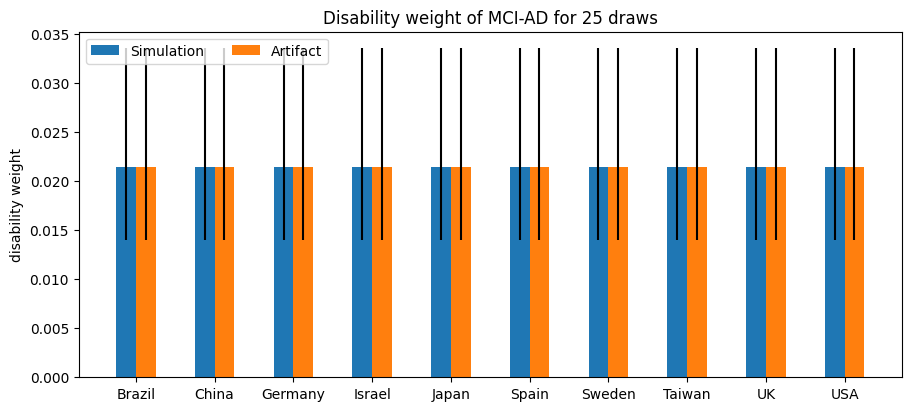

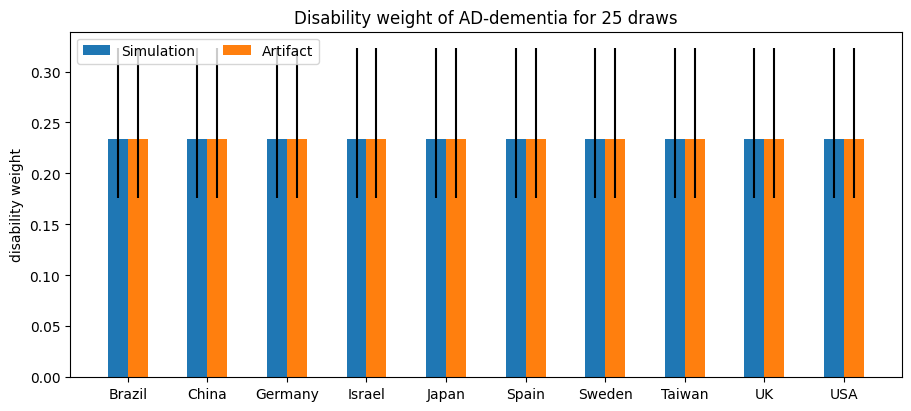

In [187]:
location = locations[0]

states = {
    'MCI-AD': 'alzheimers_mild_cognitive_impairment_state',
    'AD-dementia': 'alzheimers_disease_state',
}
artifact_dfs = [
    mci_dw,
    ad_dw.query("age_start >= 40"),
]

for (state_label, state), artifact_df in zip(states.items(), artifact_dfs):
    # sim_summary = summarize_sim_data(
    #     dws_by_age_group.query("sub_entity == @state")
    #     .groupby('location').mean())
    sim_summary = summarize_sim_data(
        ops.stratify(
            dws_by_age_group_and_sex
            .merge(age_dictionary) # merge so we can query age_start
            .query("sub_entity == @state and age_start >= 40"),
            [], # location is already in index and we don't want additional strata
            func='mean',
        )
    )
    art_summary = summarize_artifact_data(
        artifact_df[draw_cols].groupby('location').mean())

    x = np.arange(len(locations))
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(9, 4), layout='constrained')

    sources = ['Simulation', 'Artifact']
    dfs = [sim_summary, art_summary]

    for source, df in zip(sources, dfs):
        offset = width * multiplier
        err_lower = df['mean'] - df['lower']
        err_upper = df['upper'] - df['mean']
        rects = ax.bar(
            x + offset, df['mean'], width, yerr=(err_lower, err_upper),
            label=source)
        # ax.bar_label(rects, padding=3)
        multiplier += 1
        

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('disability weight')
    ax.set_title(f'Disability weight of {state_label} for 25 draws')
    ax.set_xticks(
        # x + width,
        x + (len(sources) - 1) * width / 2,
        sim_summary.index.get_level_values('location').map(location_to_short_name)
    )
    ax.legend(loc='upper left', ncols=2)
    # ax.set_ylim(0, 0.04)
    plt.show()



In [183]:
list(sim_summary['mean'].unique())

[0.2333310666926587,
 0.2333310666926585,
 0.23333106669265768,
 0.23333106669265824,
 0.23333106669266038,
 0.23333106669265813,
 0.23333106669265846,
 0.23333106669265874,
 0.23333106669265857]

In [182]:
sim_summary

,,count,mean,std,min,lower,50%,upper,max
location,scenario,,,,,,,,
Brazil,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
China,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
Germany,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
Israel,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
Japan,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
Spain,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
Sweden,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
Taiwan (Province of China),baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569
United Kingdom,baseline,25.0,0.233331,0.043373,0.175235,0.17571,0.228148,0.322948,0.351569


In [169]:
art_summary

,mean,lower,upper
location,,,
Brazil,0.233331,0.17571,0.322948
China,0.233331,0.17571,0.322948
Germany,0.233331,0.17571,0.322948
Israel,0.233331,0.17571,0.322948
Japan,0.233331,0.17571,0.322948
Spain,0.233331,0.17571,0.322948
Sweden,0.233331,0.17571,0.322948
Taiwan (Province of China),0.233331,0.17571,0.322948
United Kingdom,0.233331,0.17571,0.322948


In [172]:
art_summary['mean'].unique()

array([0.23333107, 0.23333107, 0.23333107, 0.23333107, 0.23333107,
       0.23333107, 0.23333107, 0.23333107, 0.23333107])

In [179]:
list(ad_dw.query("age_start==70 and sex=='Female'").draw_0.unique())

[0.31021239720294125,
 0.3102123972029412,
 0.31021239720294136,
 0.31021239720294114,
 0.3102123972029415,
 0.3102123972029417,
 0.3102123972029408]